In [1]:
!nvidia-smi

Wed Apr 21 13:55:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [4]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, '2998reals_ccs_data_xyz_20_20_5')
sat_t, logk, p_t, ground_disp_t = load_data(data_path, ['sat', 'logk', 'p', 'ground_disp'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)
print('p_t shape is ', p_t.shape)
print('ground_disp shape is ', ground_disp_t.shape)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
sw_t shape is  (2998, 11, 12, 40, 40)
logk shape is  (2998, 12, 40, 40)
p_t shape is  (2998, 11, 12, 40, 40)
ground_disp shape is  (2998, 11, 41, 41)


In [5]:
print('p_t max is ', np.max(p_t))
print('p_t min is ', np.min(p_t))

p_t max is  21324300.0
p_t min is  13573000.0


In [6]:
depth = 10
nr = logk.shape[0]
train_nr = 2000
test_nr = 500

In [7]:
p_t_mean = np.mean(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t_std = np.std(p_t[:train_nr, ...], axis = 0, keepdims = True)
p_t = p_t - p_t_mean
print('max p is ', np.max(p_t[:train_nr, ...]), ', min p is ', np.min(p_t[:train_nr, ...]))
max_p = np.max(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)
min_p = np.min(p_t[:train_nr, ...], axis=(0,1,2,3), keepdims = True)

max p is  2454935.75 , min p is  -1474726.6999999993


In [8]:
# epsilon = 1e-6
# p_t = (p_t - min_p)/(max_p - min_p + 1e-6)
p_t = p_t / (p_t_std + 1)

In [9]:
print('max p is ', np.max(p_t), ', min p is ', np.min(p_t))
print('max p train is ', np.max(p_t[:train_nr, ...]), ', min p train is ', np.min(p_t[:train_nr, ...]))
print('max p validation is ', np.max(p_t[test_nr:, ...]), ', min p validation is ', np.min(p_t[test_nr:, ...]))

max p is  7.385882138910094 , min p is  -5.3237042103507966
max p train is  7.385882138910094 , min p train is  -5.3237042103507966
max p validation is  7.385882138910094 , min p validation is  -5.3237042103507966


In [10]:
#step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
step_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_x = logk[:train_nr, ...]
train_y = p_t[:train_nr, step_index, :, :, :]

test_x = logk[nr-test_nr:, ...]
test_y = p_t[nr-test_nr:, step_index, :, :, :]

train_x = train_x[:, :, :, :, None]
train_y = train_y[:, :, :, :, :, None]
test_x = test_x[:, :, :, :, None]
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2000, 12, 40, 40, 1)
train_y shape is  (2000, 10, 12, 40, 40, 1)
test_x shape is  (500, 12, 40, 40, 1)
test_y shape is  (500, 10, 12, 40, 40, 1)


<Figure size 432x288 with 0 Axes>

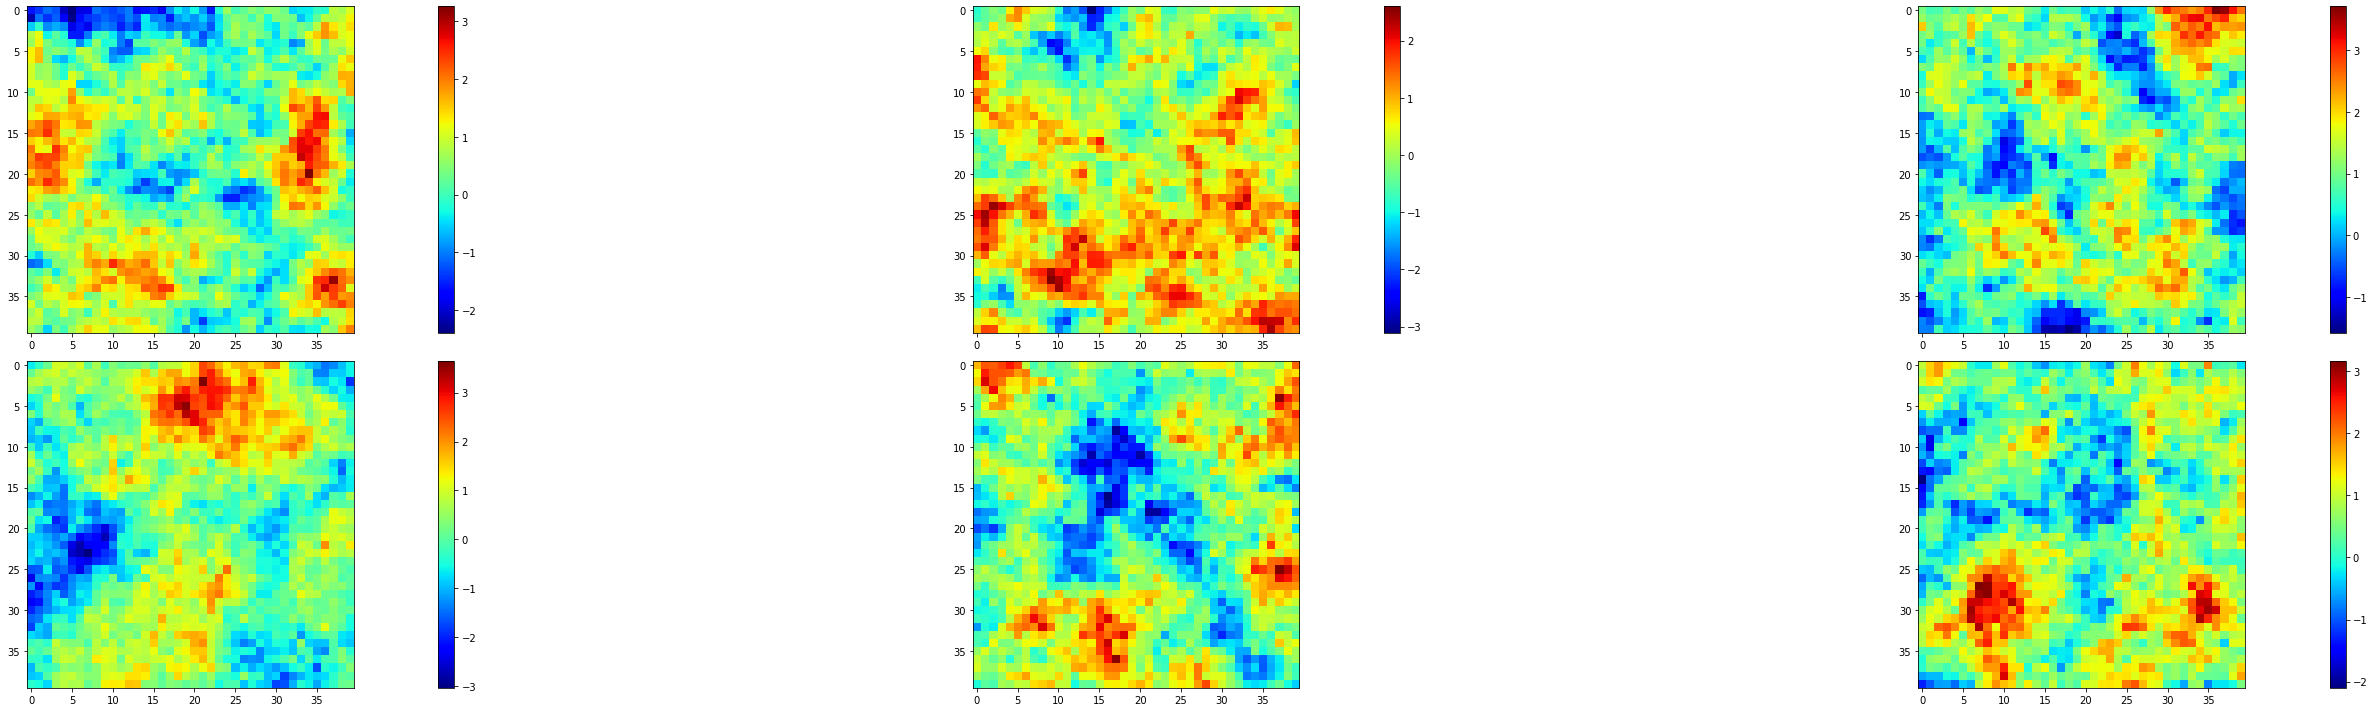

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')
ind_case = [0, 10, 20, 30, 40, 50]
plt.figure(figsize=(50,10))
for i, k in enumerate(ind_case):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_x[k, 0, :, :, 0])
    plt.colorbar(fraction=0.046)
    plt.tight_layout()
plt.show()

In [12]:
input_shape=(12, 40, 40, 1)
vae_model,_ = vae_util.create_vae(input_shape, depth)
vae_model.summary(line_length=150)





______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
image (InputLayer)                               (None, 12, 40, 40, 1)            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 6, 20, 20, 16)            448               image[0][0]                                       
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 6, 20, 20, 16)            64      

In [13]:
output_dir = 'saved_models/'
vae_model.load_weights(output_dir + 'saved-model-10steps-lr3e-4-pressure-detrend-hd-0-filter_16_32_32_64-mse-300-5333.52.h5')

In [14]:
pred_list = []
test_batch_size = 10 
batch_num = int(test_nr / test_batch_size) + 1
for i in range(batch_num):
    next_batch_idx = min((i+1)*test_batch_size, test_x.shape[0])
    pred_list.append(vae_model.predict(test_x[i*test_batch_size: next_batch_idx, ...]))

pred = np.concatenate(pred_list[:-1], axis = 0)
print(pred.shape)

(500, 10, 12, 40, 40, 1)


In [15]:
pred.shape

(500, 10, 12, 40, 40, 1)

In [16]:
p_pred = pred[:, :, :, :, :, 0]
p_true = test_y[:, :, :, :, :, 0]

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

In [18]:
p_pred.shape

(500, 10, 12, 40, 40)

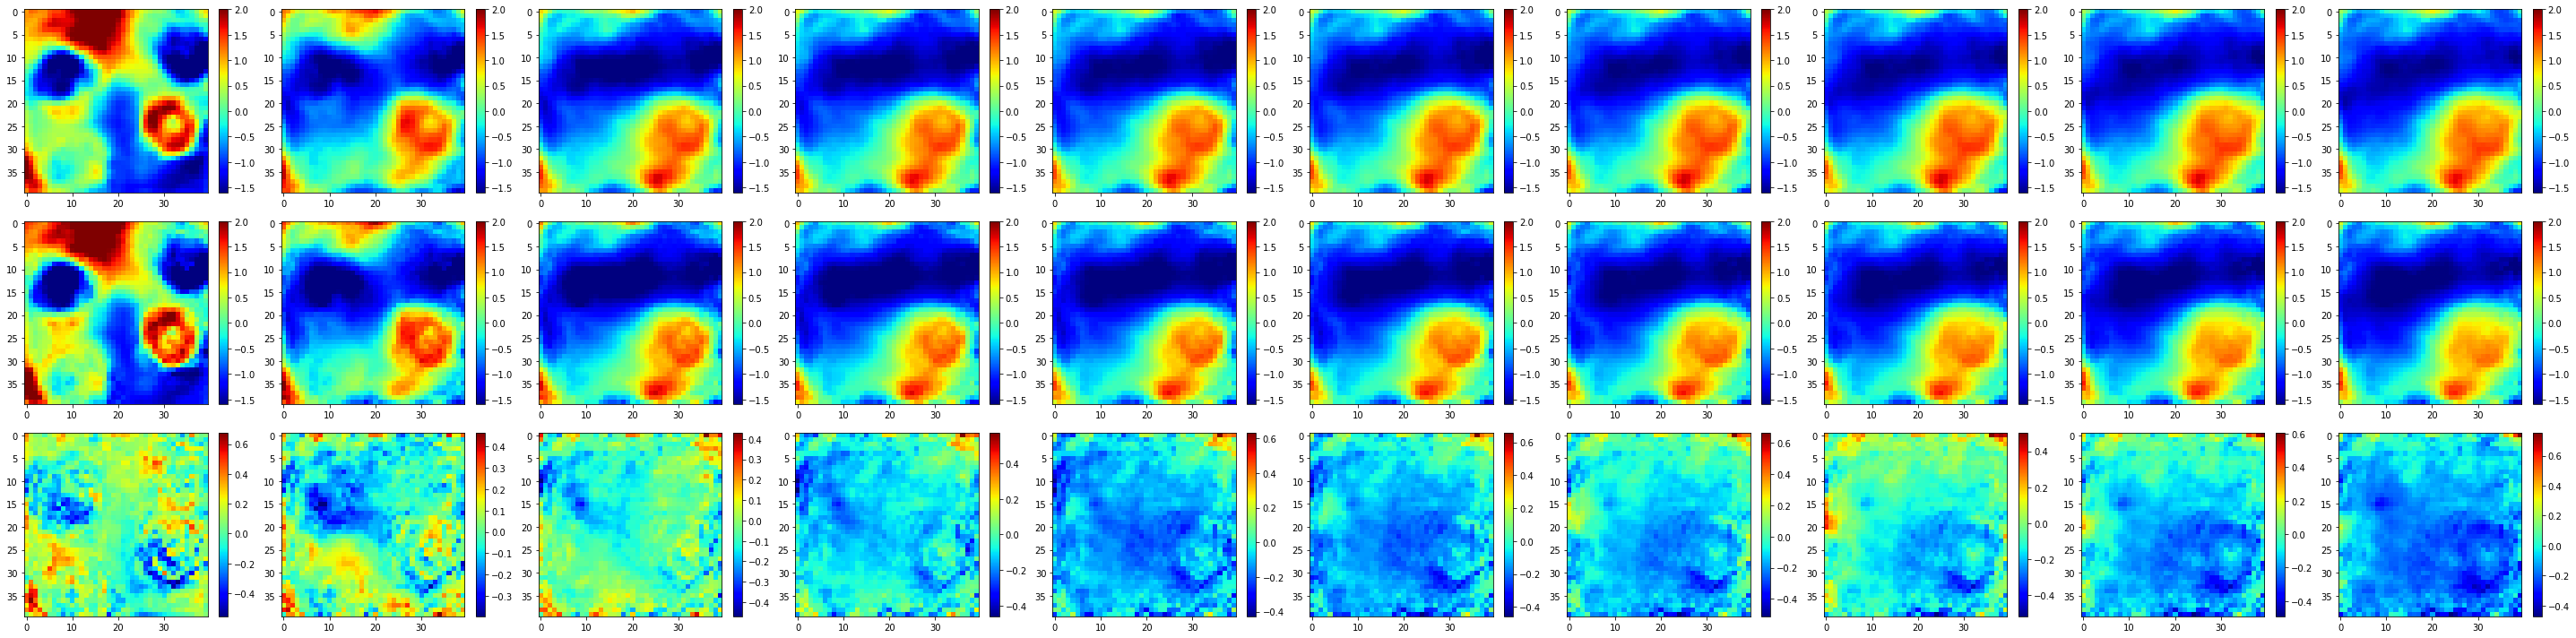

In [19]:
ind_case = [200]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(40,10))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, i_tstep, 0, :, :], vmin = -1.6, vmax = 2.0)
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, i_tstep, 0, :, :], vmin = -1.6, vmax = 2.0)
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, i_tstep, 0, :, :] - p_pred[k, i_tstep, 0, :, :])

        plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

In [20]:
p_t_std.shape

(1, 11, 12, 40, 40)

In [21]:
p_t_mean.shape

(1, 11, 12, 40, 40)

In [22]:
p_true = (p_t_std[:, 1:, :, :, :] + 1) * (p_true) + p_t_mean[:, 1:, :, :, :] 
p_pred = (p_t_std[:, 1:, :, :, :] + 1) * (p_pred) + p_t_mean[:, 1:, :, :, :] 

In [23]:
p_true.shape

(500, 10, 12, 40, 40)

In [24]:
# hw = h5py.File('p_pred_10steps_hd500_lr3e-4_filter_16_32_32_64.h5', 'w')
# hw.create_dataset('p_pred', data = p_pred)
# hw.create_dataset('p_true', data = p_true)
# hw.close()

In [25]:
np.max(p_pred)

20301739.7849136

In [26]:
np.min(p_pred)

13577142.173280867

In [27]:


def plot_model(m, nx=40, ny=40, inj_x=None, inj_y=None, prod_x=None, prod_y=None, ms=20, colorbar=False, clim=None, mc='w'):
    im = plt.imshow(m)
    if colorbar:
        plt.colorbar(fraction=0.046, pad=0.04)
    if clim:
        plt.clim(clim)
    plt.scatter(inj_x, inj_y, marker='v', s=ms, c=mc)
    plt.scatter(prod_x, prod_y, marker='o', s=ms, c=mc)
    
    # add text
    for i in range(inj_x.shape[0]):
        plt.text(inj_x[i]-2, inj_y[i] - 6, s = 'I'+str(i+1), fontsize=12, color = 'w', weight='heavy')
    
    for i in range(prod_x.shape[0]):
        plt.text(prod_x[i]-3, prod_y[i] - 6 , s = 'P'+str(i+1), fontsize=12, color = 'w', weight='heavy')
    
    plt.gca().invert_yaxis()
    return im



def plot_model_40x40_4w(m, ms=50, colorbar=False, mc='w', clim=None):
    
    obs_loc_x = [9, 10, 35, 31, 20]
    obs_loc_y = [7, 30, 15, 32, 20]
    prod_x = None
    prod_y = None
    inj_x = obs_loc_x[:1]
    inj_y = obs_loc_y[:1]
    im = plot_model(m, nx=40, ny=40, inj_x=inj_x, inj_y=inj_y, prod_x=prod_x, prod_y=prod_y, ms=ms, colorbar=colorbar, mc=mc, clim=clim)
    
    return im

In [28]:

obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]

In [29]:
p_true.max()

20479000.0

[8, 10, 35, 32]


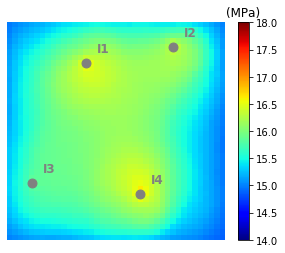

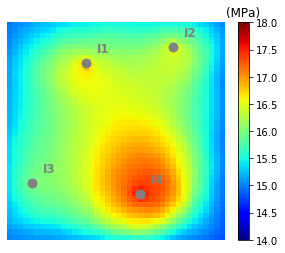

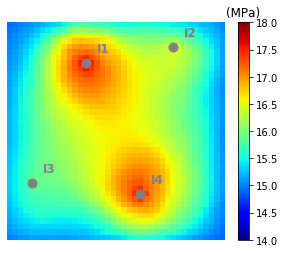

In [30]:
ind_case = [272, 223, 365]
obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]
well_loc_x = [8, 10, 35, 32]
well_loc_y = [15, 35,9, 25]
prod_x = None
prod_y = None
inj_x = well_loc_x
inj_y = well_loc_y
#inj_x = [40 - 1 - x for x in inj_x]
inj_y = [40  - 1 -  y for y in inj_y]
#, inj_y = inj_y, inj_x
print(inj_x)
for k in ind_case:
    plt.figure()
    plt.scatter(inj_y, inj_x, marker='o', s=80, c='gray')
    for i in range(len(inj_x)):
        plt.text(inj_y[i] + 2, inj_x[i] + 2, s = 'I'+str(4-i), fontsize=12, color = 'gray', weight='heavy')
        
    im = plt.imshow(p_true[k, -1, 0, ::-1, :].transpose() /1e6)
    
#     plt.scatter(inj_y, inj_x, marker='v', s=80, c='gray')
#     for i in range(len(inj_x)):
#         plt.text(inj_y[i]-2, inj_x[i] - 2, s = 'I'+str(i+1), fontsize=12, color = 'gray', weight='heavy')
        
    plt.gca().invert_yaxis()
    plt.axis('off')
    clb = plt.colorbar(fraction = 0.046, pad = 0.04)
    clb.ax.set_title('(MPa)')
    im.set_clim([14, 18])

# Compute relative error and ranks

In [31]:
relative_error = np.mean(np.abs(p_pred - p_true) / (np.max(p_true,  keepdims = True, axis = (1,2,3,4)) - np.min(p_true, keepdims = True, axis = (1,2,3,4))), axis = (1,2,3,4))

In [32]:
relative_error[249]

0.0023127242995952834

In [33]:
relative_error[382]

0.00277770691947963

In [34]:
relative_error[78]

0.002670465591104148

In [35]:
ranks = np.argsort(relative_error)

In [36]:
relative_error[8]

0.0018486536661889454

In [37]:
relative_error[499]

0.0042331699534121515

In [38]:
relative_error[379]

0.0030484117259753515

In [39]:
relative_error[272]

0.0038638913616478093

In [40]:
relative_error[223]

0.004198816791734591

In [41]:
relative_error[280]

0.0023196131523415364

In [42]:
ranks

array([  8,  66, 496, 235,  40,  28, 253, 411, 252, 326, 101,  72, 471,
        87, 487, 474,  69, 274, 466,  26,  29,   9,  31, 337, 444, 447,
       290, 271, 238, 180, 470, 156, 297, 317,  39, 163, 188, 412, 287,
       475, 401, 465, 246, 319, 251, 210, 397, 268, 482, 388,  25, 392,
        96, 178, 378, 440, 464, 209, 155, 334, 121, 145, 269,  54,  14,
       304, 351, 109, 405, 102,  86, 275, 106, 146, 452, 249, 285, 383,
       280, 430,  42, 325,  74,  59, 135, 390, 459, 439, 153, 370, 114,
       431, 129, 492, 426, 177, 484,  88, 461,   2, 181,  63, 339, 494,
       488, 123, 321, 234,  52,  12,  49,  80, 165,  33,  13, 314,  91,
       219, 434, 342, 103, 448, 421, 369, 282, 119, 116, 255, 310,  99,
       416, 428, 162, 196, 322,  62,  45,  30,  51,  32, 190, 240, 340,
       456, 467, 293, 132, 323, 237,  55, 125, 472, 174, 231,  61, 273,
       406, 202, 279, 348, 122, 477, 358, 485, 367,  78, 387, 175, 335,
       143, 381, 154, 241, 263, 228, 289,  47, 183, 454, 110, 43

In [43]:
ranks[250]

379

In [44]:
relative_error[379]

0.0030484117259753515

In [45]:
relative_error[382]

0.00277770691947963

In [46]:
np.where(ranks == 272)

(array([382]),)

In [47]:
np.where(ranks == 223)

(array([401]),)

In [48]:
np.where(ranks == 149)

(array([333]),)

In [49]:
np.where(ranks == 123)

(array([105]),)

In [50]:
np.where(ranks == 481)

(array([413]),)

In [51]:
np.where(ranks == 280)

(array([78]),)

In [52]:
picked_case = [272, 223, 280, 149, 220, 123, 481, 109]


In [53]:
np.where(ranks == 220)

(array([232]),)

In [54]:
np.where(ranks == 109)

(array([67]),)

In [55]:
ranks[300]

438

In [56]:
p_true.shape

(500, 10, 12, 40, 40)

In [57]:
p_true.min()

13577100.0

In [58]:
ranks[303]

365

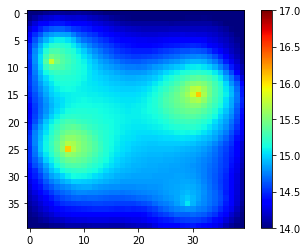

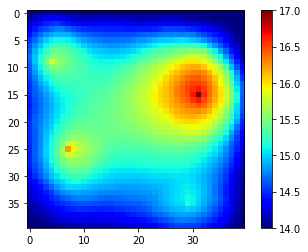

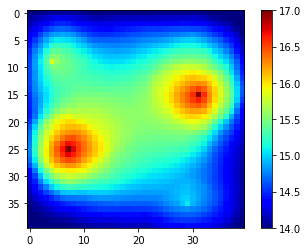

In [59]:
picked = [272, 223, 365]


for i in picked:
    plt.figure()
    plt.imshow(p_true[i, -1, -1, :, ::-1]/1e6, vmin=14, vmax = 17 )
    plt.colorbar()


365
60
250


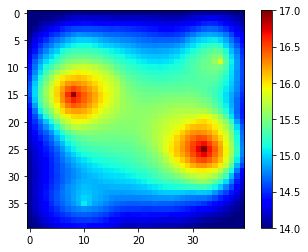

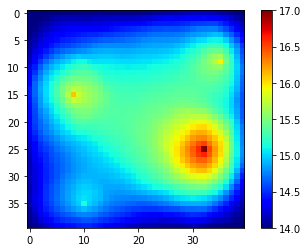

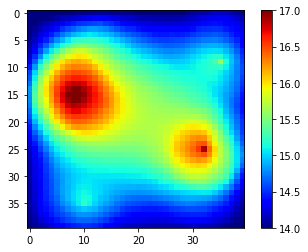

In [60]:
picked = [3,6,7]


for i in picked:
    plt.figure()
    plt.imshow(p_true[ranks[300 + i], -1, -1, :, :]/1e6, vmin=14, vmax = 17 )
    plt.colorbar()
    print(ranks[300 + i])

In [62]:

# picked_case = [365, 60, 250]

# hr = h5py.File('to_visualize_p_pred_true_10steps_3cases_above_median.h5', 'w')
# hr.create_dataset('p_pred', data = p_pred[picked_case, ...])
# hr.create_dataset('p_true', data = p_true[picked_case, ...])
# hr.create_dataset('perm', data = logk[picked_case, ...])
# hr.close()

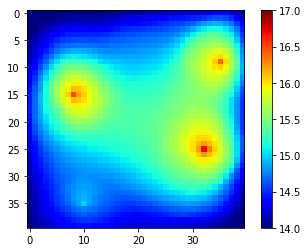

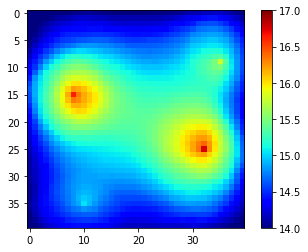

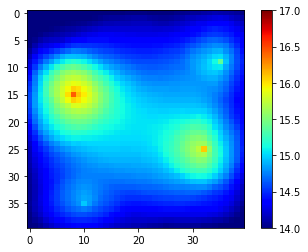

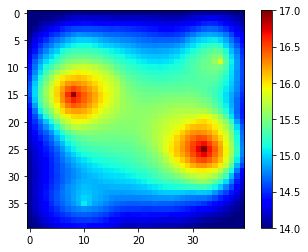

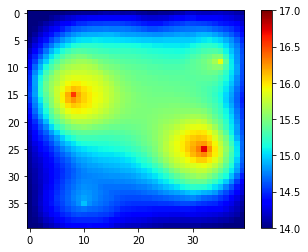

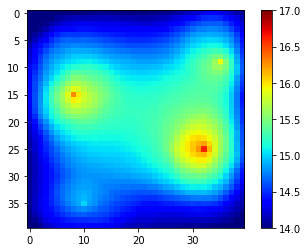

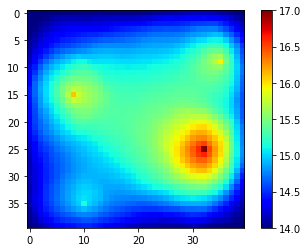

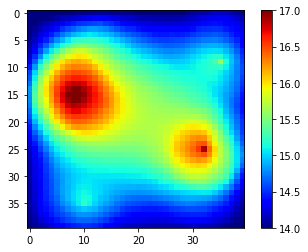

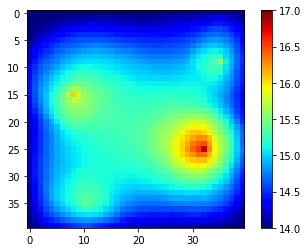

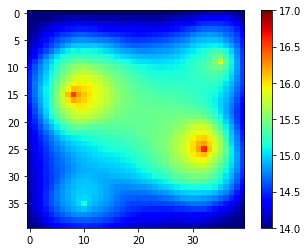

In [63]:
for i in range(10):
    plt.figure()
    plt.imshow(p_true[ranks[300 + i], -1, -1, :, :]/1e6, vmin=14, vmax = 17 )
    plt.colorbar()
    
    

In [64]:
##Compute error
p_error = np.mean(np.abs(p_pred - p_true)/(np.max(p_true,  keepdims = True, axis = (1,2,3,4)) - np.min(p_true, keepdims = True, axis = (1,2,3,4))), axis = (0,2,3,4))

In [65]:
p_error

array([0.00131703, 0.00226707, 0.00343624, 0.00398218, 0.00416327,
       0.00407673, 0.00391544, 0.00378034, 0.0036862 , 0.00362691])

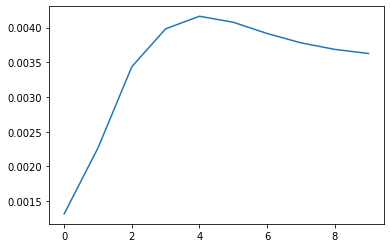

In [66]:
plt.figure()
plt.plot(p_error)
plt.show()

In [67]:
np.mean(p_error)

0.0034251403252602538

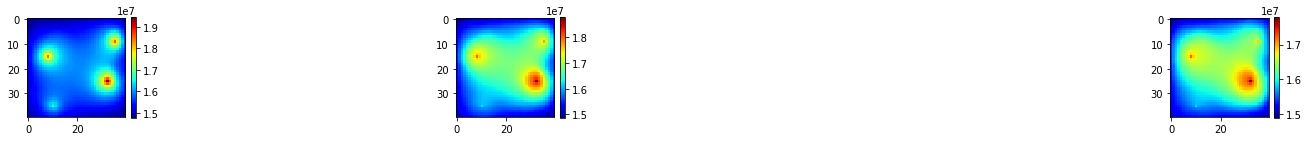

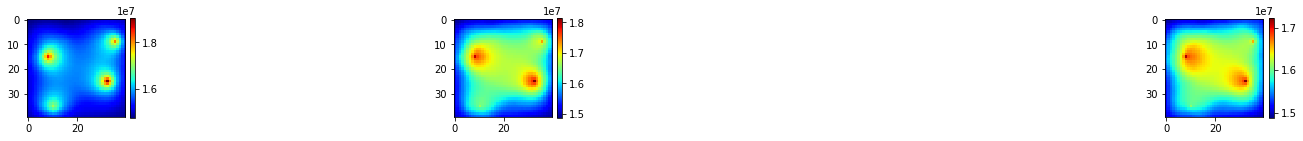

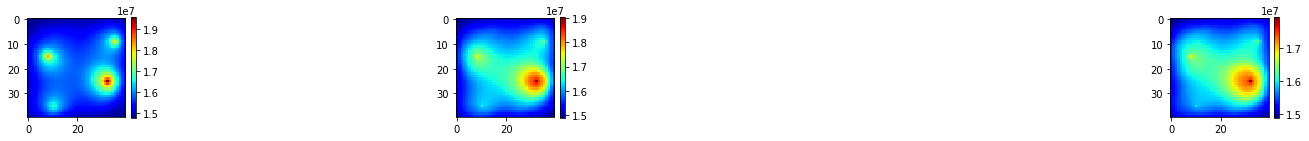

In [68]:
ind_case = [1, 6, 200]
ind_z = 0
for k in ind_case:
    plt.figure(figsize=(20,10))
    for i_tstep in[1, 4, 9]:
        plt.subplot(1, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, i_tstep, 0, :, :])
        plt.colorbar(fraction=0.046)
#         plt.subplot(3, depth, i_tstep+1+depth)
#         plt.imshow(p_true[k, i_tstep, 0, :, :])
#         plt.colorbar(fraction=0.046)
        
#         plt.subplot(3, depth, i_tstep+1+2*depth)
#         plt.imshow(p_true[k, i_tstep, 0, :, :] - p_pred[k, i_tstep, 0, :, :])

        #plt.colorbar(fraction=0.046)
        #plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

In [69]:
a = 1

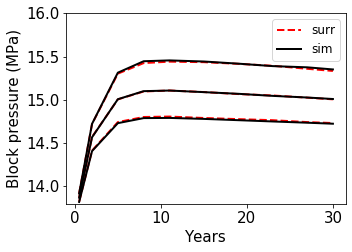

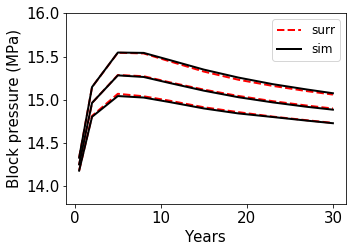

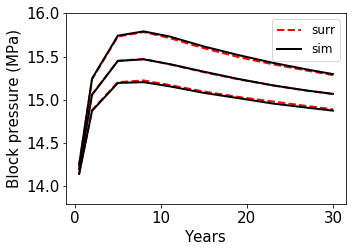

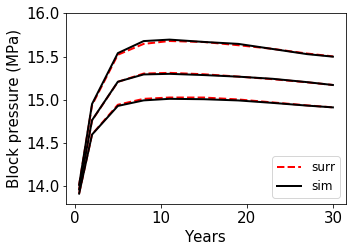

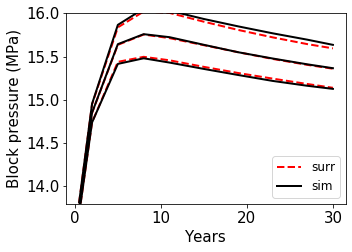

In [71]:

tsteps = [0.5, 2.0 , 5.0, 8.0, 11., 15., 19., 23., 27., 30.]


obs_loc_x = [9, 10, 35, 31, 20]
obs_loc_y = [7, 30, 15, 32, 20]

# obs_loc_x = [20]
# obs_loc_y = [20]


for i in range(len(obs_loc_x)):
    y, x = obs_loc_y[i], obs_loc_x[i]
    area_pred = p_pred[:, :, -1, y, x]
    area_true = p_true[:, :, -1, y, x]
    
    plt.figure(figsize = (5, 3.6))

    plt.plot(tsteps, np.percentile(area_pred, q = 10, axis = 0) / 1e6, 'r--', label = 'surr', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 50, axis = 0) / 1e6, 'r--', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 90, axis = 0) / 1e6, 'r--', linewidth = 2)

    plt.plot(tsteps, np.percentile(area_true, q = 10, axis = 0) / 1e6, color = 'k', label = 'sim', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 50, axis = 0) / 1e6, color = 'k', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 90, axis = 0) / 1e6, color = 'k', linewidth = 2)

    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Block pressure (MPa)', fontsize = 15)
    plt.ylim([13.8, 16])
    plt.legend( prop={'size': 12})
    plt.tight_layout()
    #plt.savefig('./saved_plots/test_pressure_well%d.pdf'%(i + 1))
    plt.savefig('./saved_plots/test_pressure_well%d.png'%(i + 1))

In [40]:
for i in range(4):
    y, x = obs_loc_y[i], obs_loc_x[i]
    area_pred = p_pred[:, :, -1, y, x]
    area_true = p_true[:, :, -1, y, x]
    
    plt.figure(figsize = (5, 3.6))

    p5 = np.percentile(area_true[:, -1], q = 5, axis = 0)
    p5_ind = np.abs(p5 - area_true[:, -1]).argmin()
    p95 = np.percentile(area_true[:, -1], q = 95, axis = 0) 
    p95_ind = np.abs(p95 - area_true[:, -1]).argmin()
    
    print('Near well {}, p5 index is {}, p95 index is {}'.format(i + 1, p5_ind, p95_ind))

Near well 1, p5 index is 272, p95 index is 223
Near well 2, p5 index is 280, p95 index is 149
Near well 3, p5 index is 220, p95 index is 123
Near well 4, p5 index is 481, p95 index is 109


<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

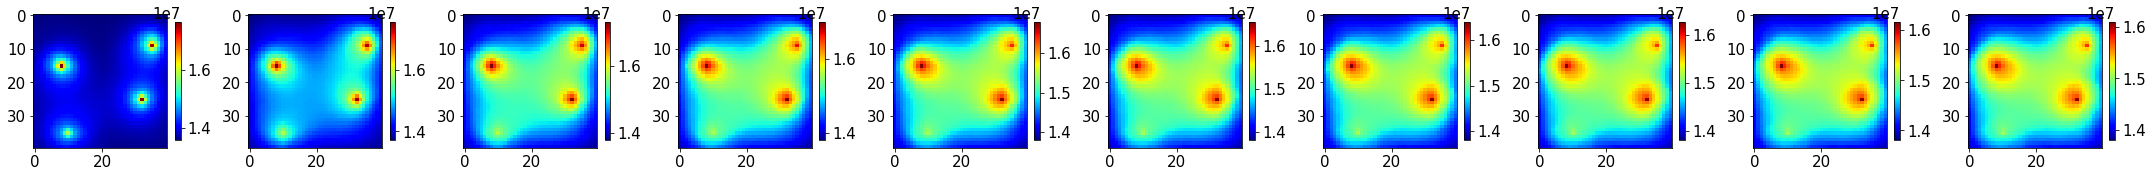

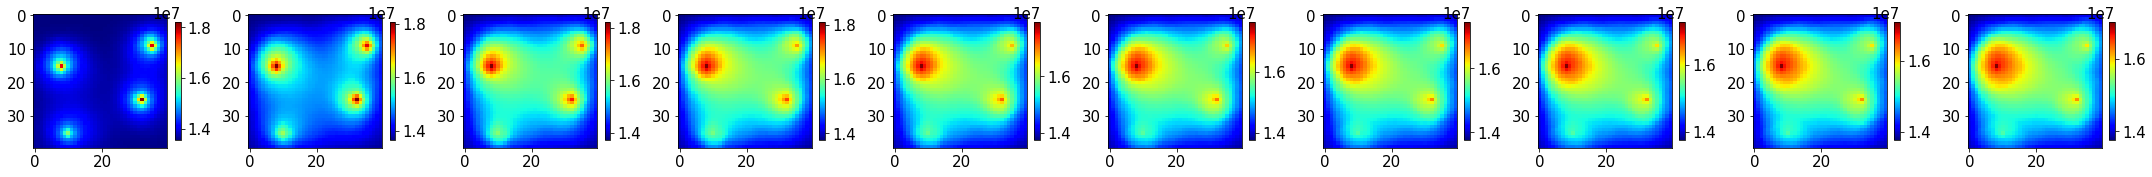

In [41]:
for k in [272, 223]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(p_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

In [ ]:
picked_case = [272, 223]
picked_tstep = [1, 2, -1]

for k in picked_case:
    for t in picked_tstep:
        
        plt.figure(figsize=(5, 5))
        plt.imshow(p_true[k, t, -1, :, :] / 1e6)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        
        plt.savefig('./saved_field_plots/p_true_tstep{}_case{}.png'.format(t, k))
        
        
        plt.figure(figsize=(5, 5))
        plt.imshow(p_pred[k, t, -1, :, :] / 1e6)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        plt.savefig('./saved_field_plots/p_pred_tstep{}_case{}.png'.format(t, k))

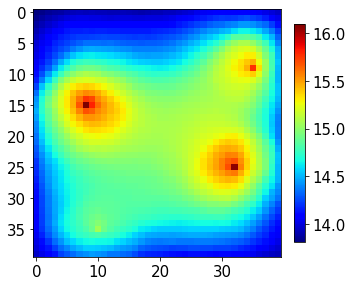

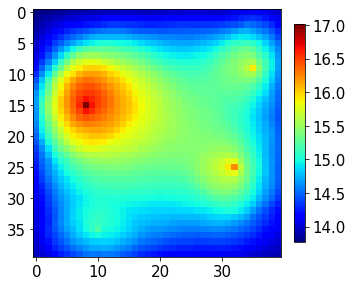

In [42]:
for k in [272, 223]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(p_true[k, -1, -1, :, :] / 1e6)
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

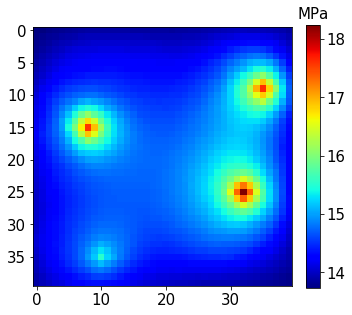

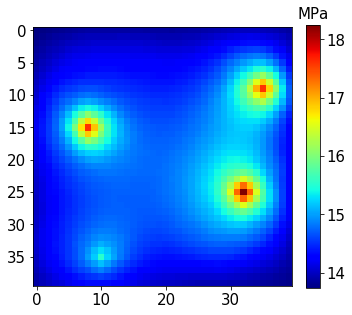

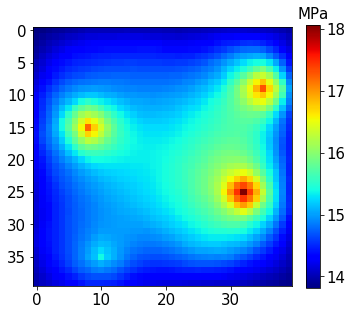

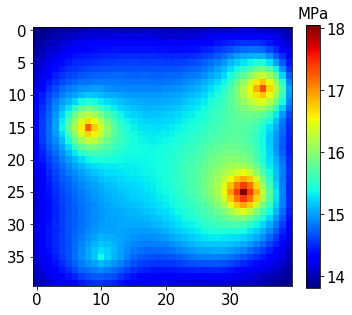

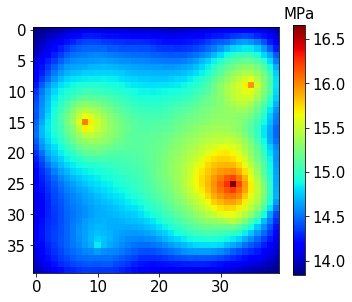

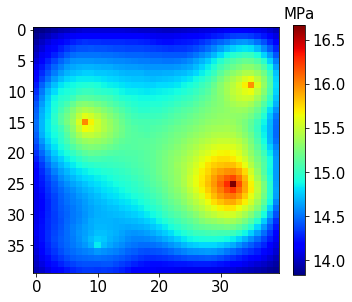

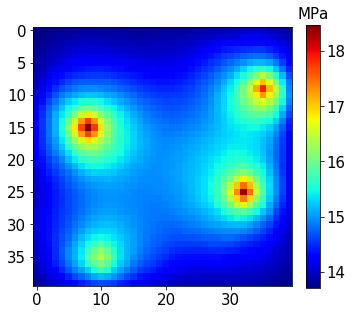

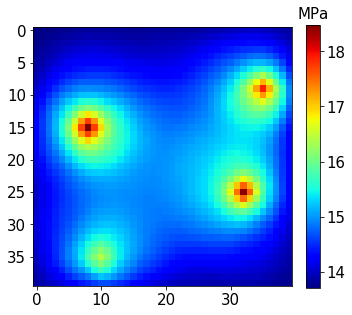

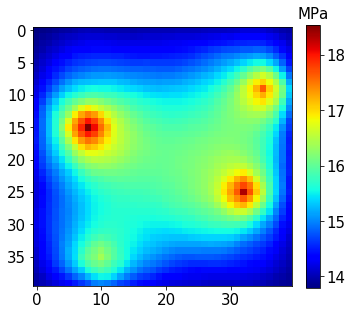

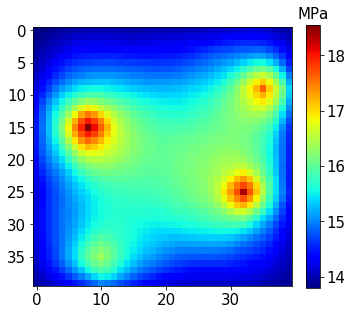

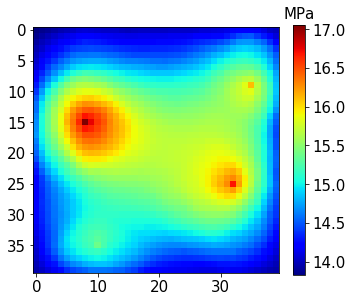

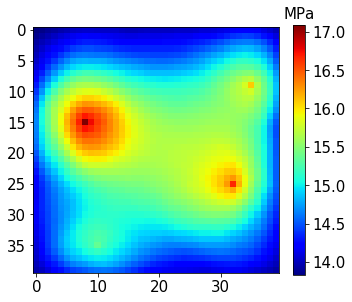

In [47]:
picked_case = [280, 149]
picked_tstep = [1, 2, -1]

for k in picked_case:
    for t in picked_tstep:
        
        plt.figure(figsize=(5, 5))
        plt.imshow(p_true[k, t, -1, :, :] / 1e6)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        
        plt.savefig('./saved_field_plots/p_true_tstep{}_case{}.png'.format(t, k))
        
        
        plt.figure(figsize=(5, 5))
        plt.imshow(p_pred[k, t, -1, :, :] / 1e6)
        clb = plt.colorbar(fraction = 0.046)
        clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        plt.savefig('./saved_field_plots/p_pred_tstep{}_case{}.png'.format(t, k))



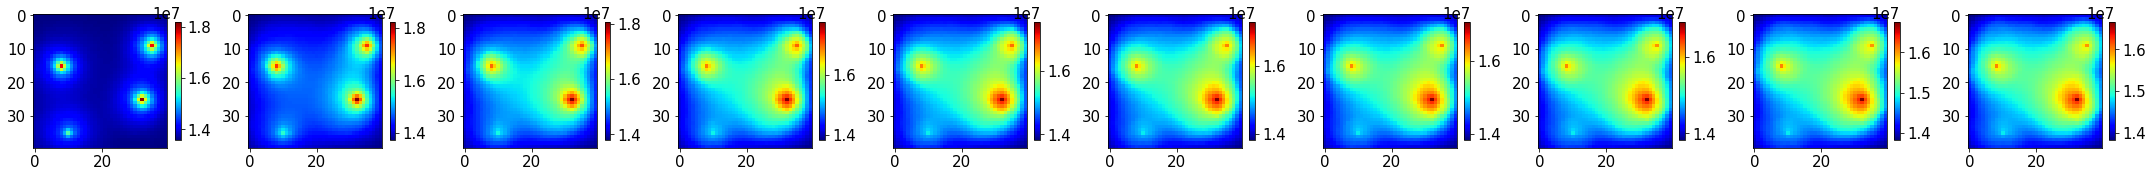

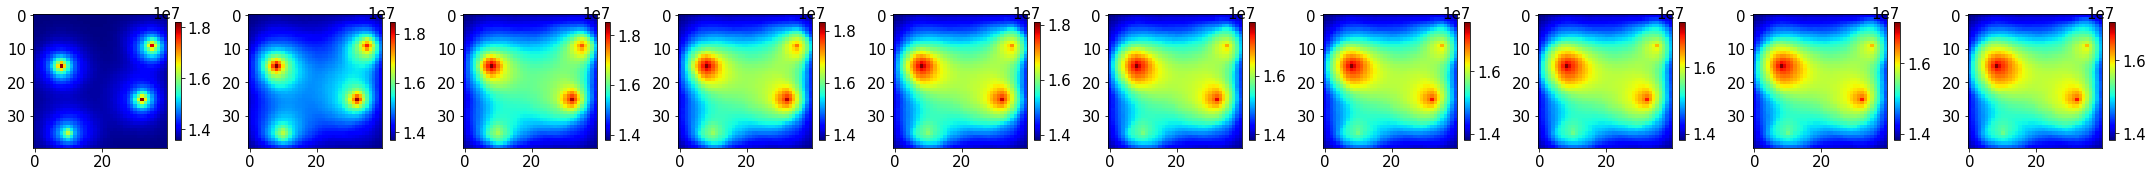

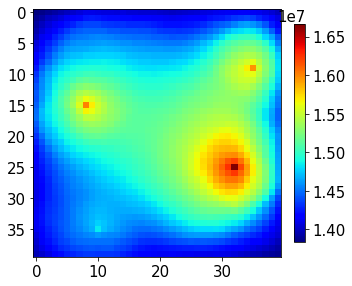

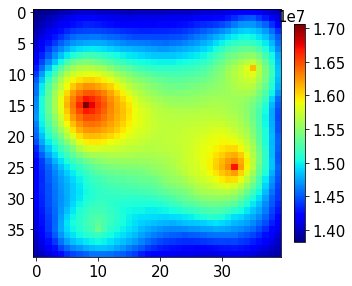

In [38]:
for k in [280, 149]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(p_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()
for k in [280, 149]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(p_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

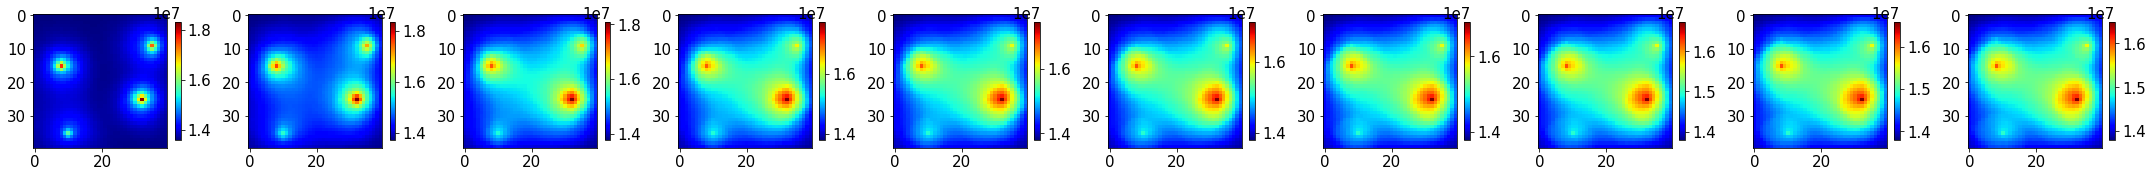

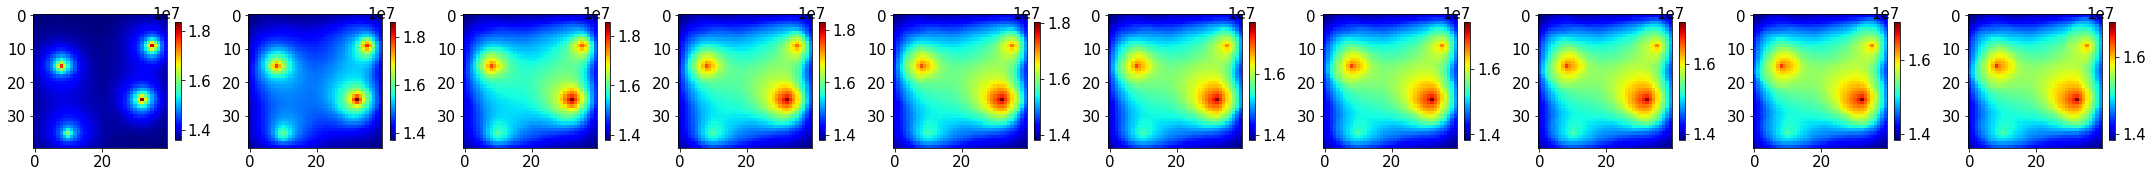

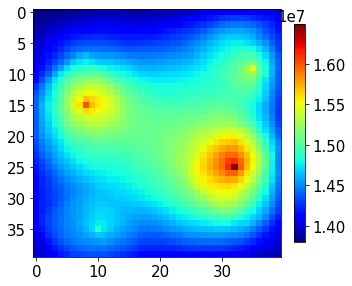

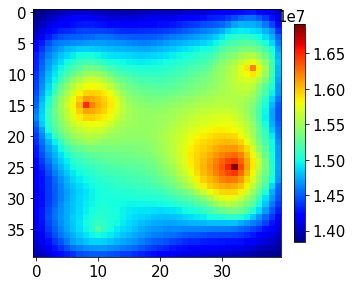

In [39]:
for k in [220, 123]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(p_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()
for k in [220, 123]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(p_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

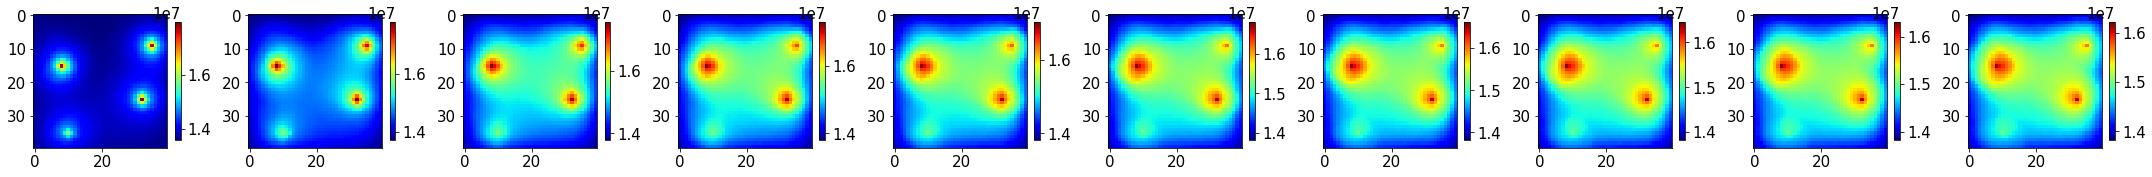

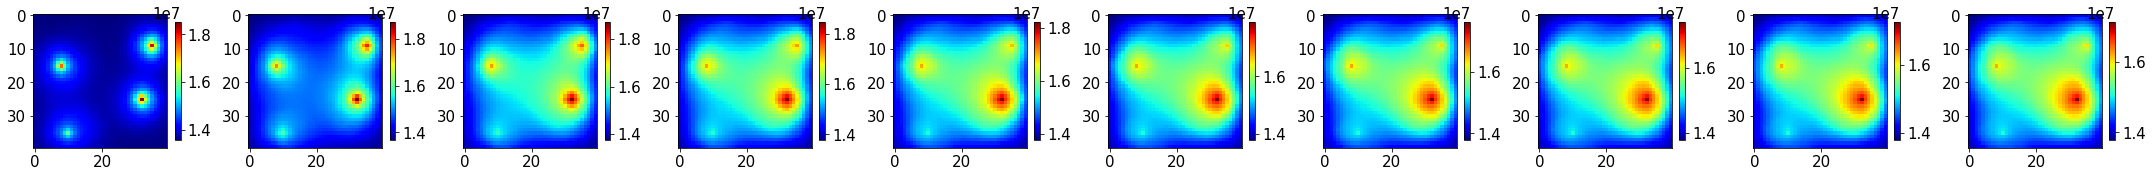

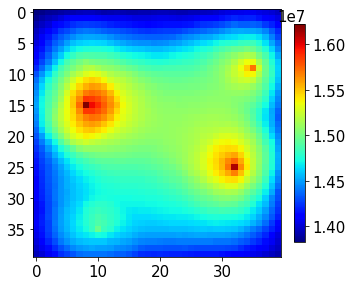

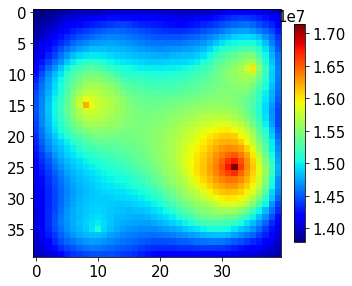

In [40]:
for k in [481, 109]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(p_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()
for k in [481, 109]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(p_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

In [ ]:


picked_case = [272, 223, 280, 149, 220, 123, 481, 109]

hr = h5py.File('to_visualize_p_and_sat_pred_true_10steps_p5_p95.h5', 'w')
hr.create_dataset('p_pred', data = p_pred[picked_case, ...])
hr.create_dataset('p_true', data = p_true[picked_case, ...])
hr.create_dataset('sat_pred', data = sat_pred)
hr.create_dataset('sat_true', data = sat_true)
hr.create_dataset('perm', data = logk[picked_case, ...])
hr.close()

In [ ]:
nx, ny, nz = 40, 40, 12
from mpl_toolkits.mplot3d import Axes3D 
voxels = np.ones((nx,ny,nz))
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [ ]:
max_ = np.max(p_pred)
min_ = np.min(p_pred)

In [ ]:
i_tstep = 1
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) / (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = (data[:, :, ::-1] - min_) / (max_ - min_)
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("pressure true %d" % (k+1))
    plt.show()

In [ ]:
hr = h5py.File('pressure_pred_10steps_bs4_hd0_lr3e-4_filter_16_32_32_64.h5', 'w')
hr.create_dataset('p_pred', data = p_pred)
hr.create_dataset('p_true', data = p_true)
hr.close()

In [ ]:
hr = h5py.File("to_visualize_sat_pred_true_10steps.h5", 'r')
sat_pred, sat_true = np.array(hr.get('sat_pred')), np.array(hr.get('sat_true'))
hr.close()

In [ ]:
sat_pred.dtype

In [49]:
hr.close()

In [54]:
picked_case = list(range(10))

hr = h5py.File('to_visualize_p_and_sat_pred_true_10steps.h5', 'w')
hr.create_dataset('p_pred', data = p_pred[picked_case, ...])
hr.create_dataset('p_true', data = p_true[picked_case, ...])
hr.create_dataset('sat_pred', data = sat_pred)
hr.create_dataset('sat_true', data = sat_true)
hr.create_dataset('perm', data = logk[picked_case, ...])
hr.close()

In [35]:
# i_tstep = 3
# for k in [1, 10, 100, 200, 300]:
#     fig = plt.figure(figsize=(6, 12))
#     ax = fig.add_subplot(2, 1, 1, projection='3d')
#     data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
#     data = (data[:, :, ::-1] - min_) /  (max_ - min_)
#     colors = plt.cm.jet(data)
#     ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
#     axisEqual3D(ax)
#     ax.voxels(voxels, facecolors=colors, edgecolor=None)
#     plt.title("pressure prediction %d" % (k+1))
#     ax = fig.add_subplot(2, 1, 2, projection='3d')
#     data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
#     data = (data[:, :, ::-1] - min_) /  (max_ - min_)
#     colors = plt.cm.jet(data)
#     ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
#     axisEqual3D(ax)
#     ax.voxels(voxels, facecolors=colors, edgecolor=None)
#     plt.title("pressure true %d" % (k+1))
#     plt.show()

In [36]:
# i_tstep = -1
# for k in [1, 10, 100, 200, 300]:
#     fig = plt.figure(figsize=(6, 12))
#     ax = fig.add_subplot(2, 1, 1, projection='3d')
#     data = p_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
#     data = (data[:, :, ::-1] - min_) /  (max_ - min_)
#     colors = plt.cm.jet(data)
#     ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
#     axisEqual3D(ax)
#     ax.voxels(voxels, facecolors=colors, edgecolor=None)
#     plt.title("pressure prediction %d" % (k+1))
#     ax = fig.add_subplot(2, 1, 2, projection='3d')
#     data = p_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
#     data = (data[:, :, ::-1] - min_) /  (max_ - min_)
#     colors = plt.cm.jet(data)
#     ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
#     axisEqual3D(ax)
#     ax.voxels(voxels, facecolors=colors, edgecolor=None)
#     plt.title("pressure true %d" % (k+1))
#     plt.show()

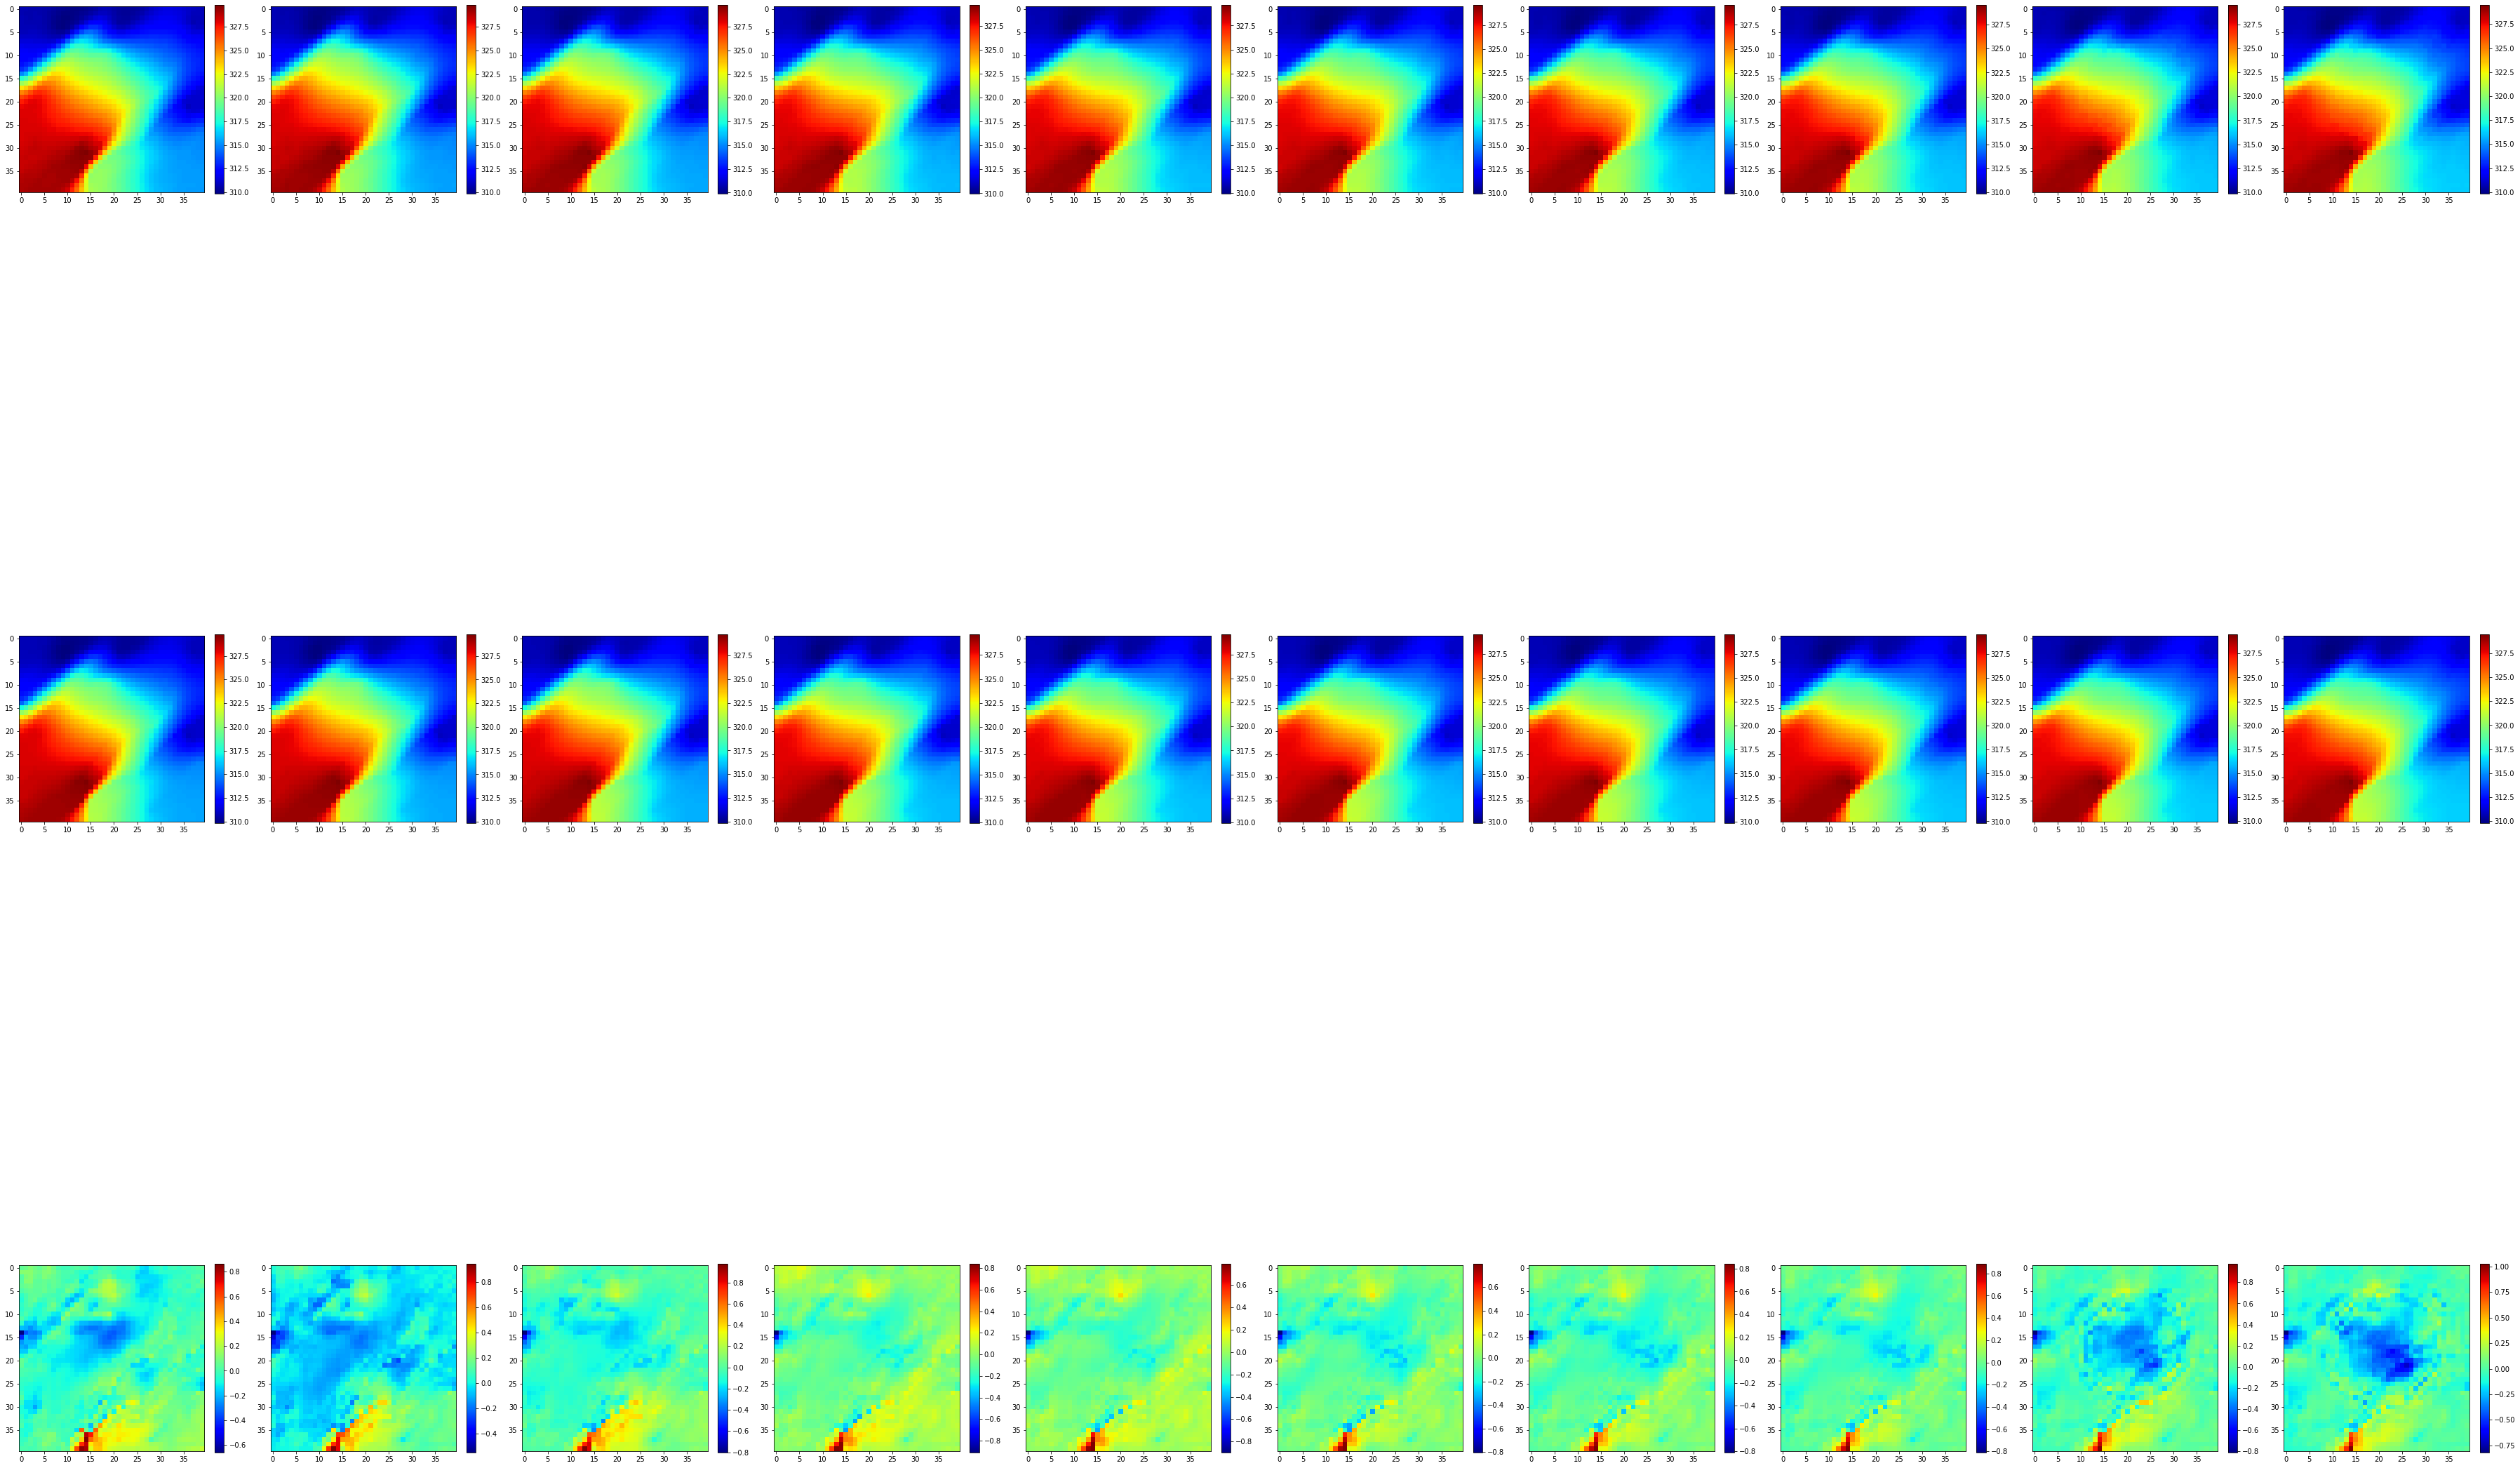

In [28]:
ind_z = 2
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep] - p_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()

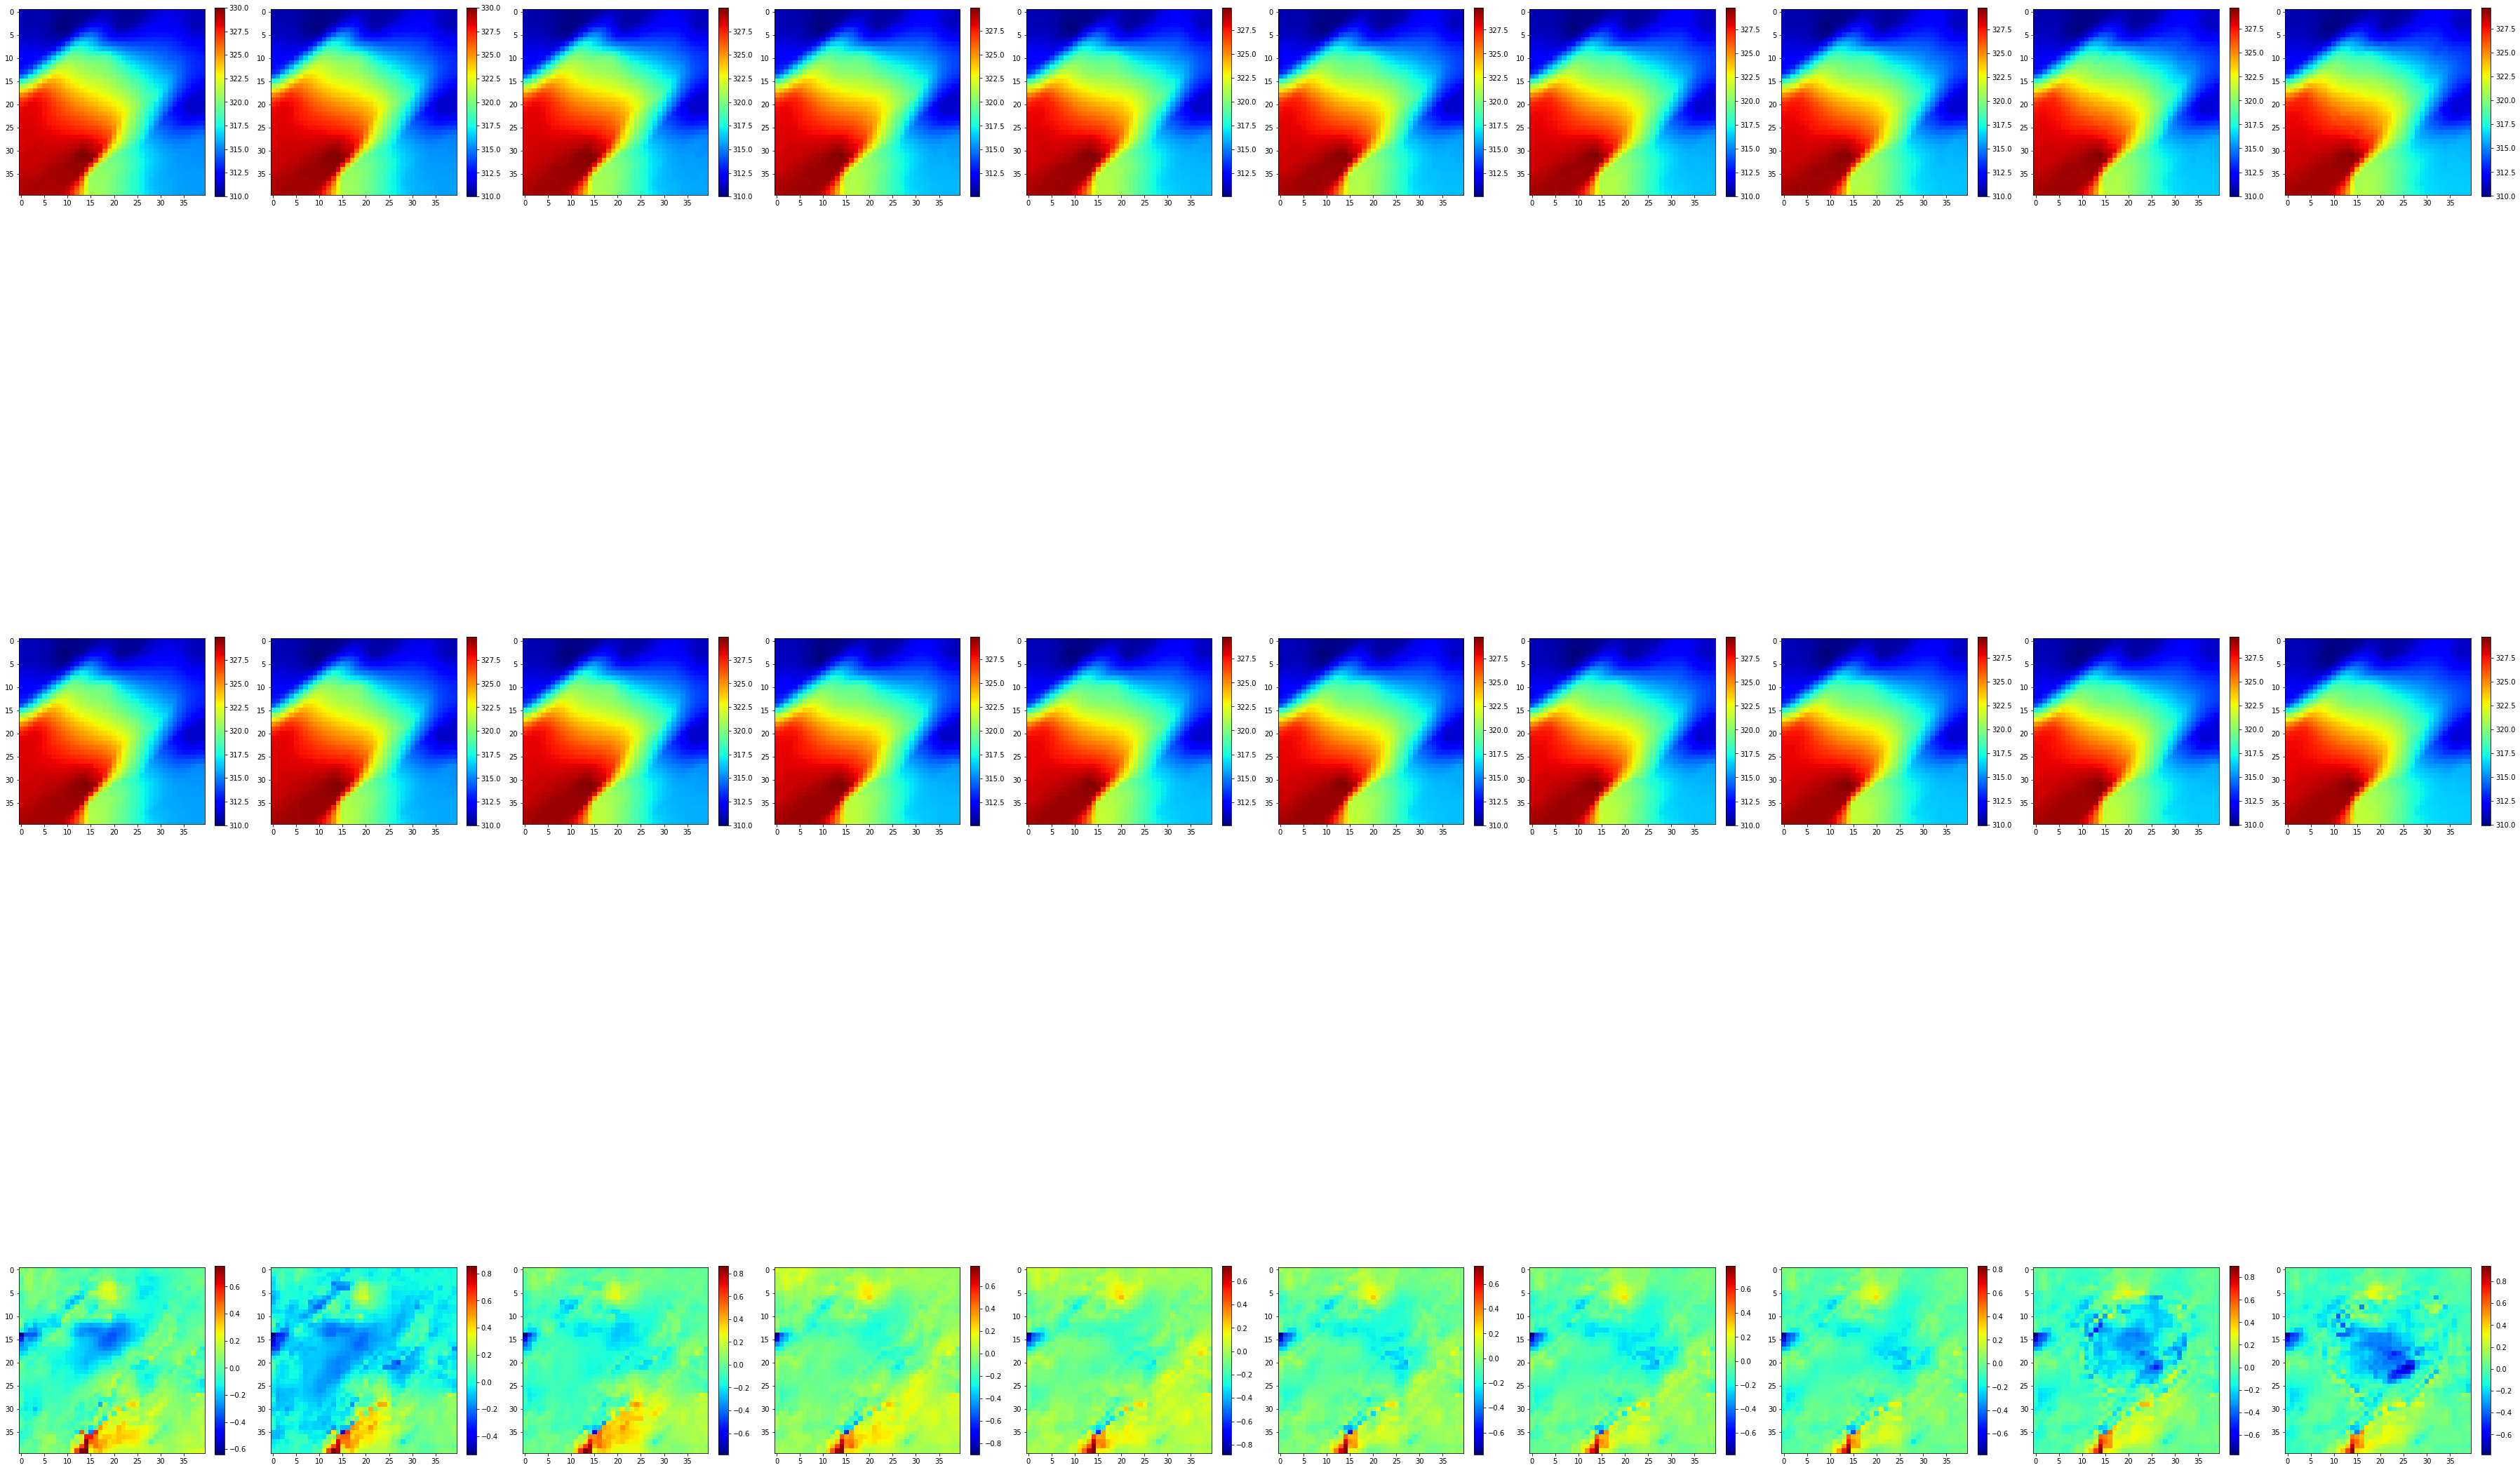

In [29]:
ind_z = 3
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(p_pred[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(p_true[k, ind_z, :, :, i_tstep] - p_pred[k, ind_z, :, :, i_tstep])

        plt.colorbar(fraction=0.046)
        plt.tight_layout()
plt.show()